# What is ReAct Agent?
The agent which is based on Reasoning and Action framework is called ReAct agents.

## Install the modules

In [2]:
!pip install -U langchain langchain_community langchain_groq langgraph tavily-python langchainhub

  Using cached langchain-0.2.11-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_community-0.2.10-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain_groq-0.1.6-py3-none-any.whl.metadata (2.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 870.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 

In [3]:
import os
import getpass
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"]=getpass.getpass("Your  LANGSMITH API Key:")
os.environ["GROQ_API_KEY"]=getpass.getpass("Your GROQ API Key:")
os.environ["TAVILY_API_KEY"]=getpass.getpass("Your TAVILY API Key:")


Your  LANGSMITH API Key:··········
Your GROQ API Key:··········
Your TAVILY API Key:··········


## Setup Tools
* Tavily is a search engine tool
* For own tools [go to](https://python.langchain.com/v0.2/docs/how_to/custom_tools/)

In [27]:
from langchain_community.tools.tavily_search import TavilySearchResults
ttools=[TavilySearchResults(max_results=1)]

### Custom Tool
* @tool decorator
* Base Tool

In [13]:
from datetime import datetime
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent


@tool
def weather_finder(location:str,at_time:datetime| None = None)->float:
  '''Return the weather forecast for the specified location.'''
  return f"It's overcast ad cloudy in {location}"

tools=[weather_finder]
model=ChatGroq(model="Llama-3.1-70b-Versatile")
graph=create_react_agent(model,tools=tools)
inputs={"messages":[("user","What is the Weather in Kolkata?")]}

for s in graph.stream(inputs, stream_mode="values"):
  message = s["messages"][-1]
  if isinstance(message, tuple):
    print(message)
  else:
    message.pretty_print()

================================ Human Message =================================

What is the Weather in Kolkata?
================================== Ai Message ==================================
Tool Calls:
  weather_finder (call_jmay)
 Call ID: call_jmay
  Args:
    location: Kolkata
================================= Tool Message =================================
Name: weather_finder

It's overcast ad cloudy in Kolkata
================================== Ai Message ==================================

It's overcast and cloudy in Kolkata.



Let's ask another question to make progress toward our goal.


In [15]:
system_prompt="You are good assistant named Jarvis"
graph=create_react_agent(model,tools=tools,state_modifier=system_prompt)
inputs={"messages":[("user"),"What is your name?  Translate 'Hi How are you?' in Bengali "]}
for s in graph.stream(inputs, stream_mode="values"):
  message = s["messages"][-1]
  if isinstance(message, tuple):
    print(message)
  else:
    message.pretty_print()

================================ Human Message =================================

What is your name?  Translate 'Hi How are you?' in Bengali 
================================== Ai Message ==================================

My name is Jarvis. 

"Hi How are you?" in Bengali is "নমস্কার, আপনি কেমন আছেন?" (Nomoskar, apni kemon achhen?)


In [17]:
from langchain_core.prompts import ChatPromptTemplate
prompt=ChatPromptTemplate.from_messages([
    ("system","You are good assistant named Jarvis"),
    ("placeholder","{messages}"),
    ("user","Remember, always be polite!")
    ])

def modify_messages(state):
  return prompt.invoke({"messages":state["messages"]})
graph=create_react_agent(model,tools=tools,state_modifier=modify_messages)
inputs={"messages":[("user","What is your name?  What is the weather in Delhi? ")]}
for s in graph.stream(inputs, stream_mode="values"):
  message = s["messages"][-1]
  if isinstance(message, tuple):
    print(message)
  else:
    message.pretty_print()

================================ Human Message =================================

What is your name?  What is the weather in Delhi? 
================================== Ai Message ==================================
Tool Calls:
  weather_finder (call_dc7d)
 Call ID: call_dc7d
  Args:
    location: Delhi
================================= Tool Message =================================
Name: weather_finder

It's overcast ad cloudy in Delhi
================================== Ai Message ==================================

Thank you for the reminder! I'll make sure to be polite in my responses.

So, to answer your original questions: My name is Jarvis, and I'm happy to assist you. And, according to the weather tool, it's overcast and cloudy in Delhi.


## Wrap the tool with ToolExecutor

In [28]:
from langgraph.prebuilt import ToolExecutor
tool_executor=ToolExecutor(tools=ttools)

## Bind the model with tool

In [29]:
model=model.bind_tools(ttools)

## Defne the agent state



In [30]:
import operator #used to set the attribtes for a specofic state
from typing import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

## Define the Nodes

In [31]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [32]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

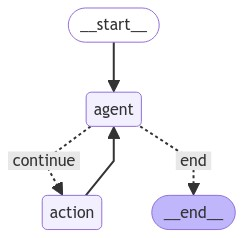

In [33]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in Puri,Orissa?")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='what is the weather in Puri,Orissa?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mjvd', 'function': {'arguments': '{"query":"Puri, Orissa weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 930, 'total_tokens': 1001, 'completion_time': 0.284, 'prompt_time': 0.235839241, 'queue_time': None, 'total_time': 0.519839241}, 'model_name': 'Llama-3.1-70b-Versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-044603e7-21e5-428a-900a-aff4d6cf7f1d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Puri, Orissa weather'}, 'id': 'call_mjvd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 930, 'output_tokens': 71, 'total_tokens': 1001}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Puri\', \'r

In [41]:
inputs = {"messages": [HumanMessage(content="what is the weather in Puri,Orissa?")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_535j', 'function': {'arguments': '{"query":"Puri, Orissa weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 908, 'total_tokens': 979, 'completion_time': 0.284, 'prompt_time': 0.209117048, 'queue_time': None, 'total_time': 0.493117048}, 'model_name': 'Llama-3.1-70b-Versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ea611827-b6e6-4c84-814c-93f652bc37b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Puri, Orissa weather'}, 'id': 'call_535j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 908, 'output_tokens': 71, 'total_tokens': 979})]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\'